## 0.  Google Drive Amount

In [2]:
import os, sys 
from google.colab import drive 
drive.mount('/content/drive') 
nb_path = '/content/drive/My Drive/Colab Notebooks/novel_sentiment_analysis'

os.chdir(nb_path)
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/novel_sentiment_analysis'

## 1. Importing Library

In [3]:
import multiprocessing

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
# !python -m spacy download en
# !python -m spacy download en_core_web_sm

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


# visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


## 2. Loading Text File

In [4]:
file_path = 'father_goriot.txt'

text_data = []
with open(file_path) as f:
    while True:
        line = f.readline()
        if line == '\n': # delete new line mark
            continue
        line = line.replace('\n', '') # delete new line mark in end of each sentence
        if not line:
            break
        text_data.append(line)

print(text_data[:5])

['Father Goriot', 'I', 'Mme. Vauquer (nee de Conflans) is an elderly person, who for the past forty years has', 'kept a lodging–house in the Rue Nueve–Sainte–Genevieve, in the district that lies between the Latin Quarter and the Faubourg Saint–Marcel. Her house (known in the neighborhood as the Maison Vauquer) receives men and women, old and young, and no word has ever been breathed against her respectable establishment; but, at the same time, it must be said that as a matter of fact no young woman has been under her roof for thirty years, and that if a young man stays there for any length of time it is a sure sign that his allowance must be of the slenderest. In 1819, however, the time when this drama opens, there was an almost penniless young girl among Mme. Vauquer’s boarders.', 'That word drama has been somewhat discredited of late; it has been overworked and twisted to strange uses in these days of dolorous literature; but it must do service again here, not because this story is d

## 3. Checking Text Data Frame

In [5]:
text_df = pd.DataFrame(text_data)
text_df.columns = ['sentence']
print("\n")
print("#"*60)
print("head of text data frame")
print(text_df.head(10))
print(text_df.tail(10))



############################################################
head of text data frame
                                            sentence
0                                      Father Goriot
1                                                  I
2  Mme. Vauquer (nee de Conflans) is an elderly p...
3  kept a lodging–house in the Rue Nueve–Sainte–G...
4  That word drama has been somewhat discredited ...
5  Will any one without the walls of Paris unders...
6  course triumphant. And you, too, will do the l...
7  The lodging–house is Mme. Vauquer’s own proper...
8  In that district the pavements are clean and d...
9                                                   
                                               sentence
2217  The two priests, the chorister, and the beadle...
2218  The ecclesiatics chanted a psalm, the Libera n...
2219  “There is no one else to follow us,” remarked ...
2220                                                   
2221           and so save time; it is half–past f

## 4. Preprocessing Text Data

In [6]:
t = time()
print("\n")
print("#"*60)

print("loading spacy preprocessor...")

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
# nlp = spacy.load("en_core_web_sm")

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)


print("lower, remove special token...")
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in text_df['sentence'])

print("lemmatizing, removing stopwords, removing short sentence...")
txt = [cleaning(text_df) for text_df in nlp.pipe(brief_cleaning, batch_size=5000)]


text_df_clean = pd.DataFrame({'preprocessed_sentence': txt})
print("drop NA, drop duplicates...")
text_df_clean = text_df_clean.dropna().drop_duplicates()
print()
print(text_df_clean.shape)
print(text_df_clean.head(10))
print()


print()
print('Using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences...')
sentences = [row.split() for row in text_df_clean['preprocessed_sentence']]
bigram_model = Phrases(sentences, min_count=30, progress_per=10000)

print("example of bigram vocab")
list(bigram_model.vocab.keys())[:5]

print("change senteces using bigram...")
for i, sentence in enumerate(sentences):
    bigram_s = bigram_model[sentence]
    if sentence != bigram_s:
        sentences[i] = bigram_s
        #print(f'{i}\t', "--"*20)
        #print(f"raw    sentences: {sentence}")
        #print(f"Bigram sentences: {bigram_s}")
print()
print("example of preprocesed sentences")
for i in range(5):
    print(f"sentence {i}: \t", sentences[i])
print()


# word frequency check
"""
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]
"""

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))



############################################################
loading spacy preprocessor...
lower, remove special token...
lemmatizing, removing stopwords, removing short sentence...


INFO - 13:04:20: NumExpr defaulting to 2 threads.
INFO - 13:04:20: collecting all words and their counts
INFO - 13:04:20: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:04:20: collected 40434 word types from a corpus of 43563 words (unigram + bigrams) and 1983 sentences
INFO - 13:04:20: using 40434 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


drop NA, drop duplicates...

(1983, 1)
                                preprocessed_sentence
2   mme vauquer nee de conflans elderly person pas...
3   keep lodging house rue nueve sainte genevieve ...
4   word drama somewhat discredit late overwork tw...
5   wall paris understand open doubt audience appr...
6   course triumphant like book white hand sink cu...
7   lodging house mme vauquer s property stand low...
8               district pavement clean dry mud water
10  gutter grass grow chink wall heedless passer f...
13  lodging house right angle road look little gar...
14  vauquer read beneath small letter lodging sex etc


Using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences...
example of bigram vocab
change senteces using bigram...


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")



example of preprocesed sentences
sentence 0: 	 ['mme_vauquer', 'nee', 'de', 'conflans', 'elderly', 'person', 'past', 'year']
sentence 1: 	 ['keep', 'lodging', 'house', 'rue', 'nueve', 'sainte', 'genevieve', 'district', 'lie', 'latin', 'quarter', 'faubourg', 'saint', 'marcel', 'house', 'know', 'neighborhood', 'maison', 'vauquer', 'receive', 'man', 'woman', 'old', 'young', 'word', 'breathe', 'respectable', 'establishment', 'time', 'say', 'matter', 'fact', 'young', 'woman', 'roof', 'thirty', 'year', 'young_man', 'stay', 'length', 'time', 'sure', 'sign', 'allowance', 'slender', 'time', 'drama', 'open', 'penniless', 'young', 'girl', 'mme_vauquer', 's', 'boarder']
sentence 2: 	 ['word', 'drama', 'somewhat', 'discredit', 'late', 'overwork', 'twist', 'strange', 'use', 'day', 'dolorous', 'literature', 'service', 'story', 'dramatic', 'restricted', 'sense', 'word', 'tear', 'shed', 'intra', 'et', 'extra', 'muro']
sentence 3: 	 ['wall', 'paris', 'understand', 'open', 'doubt', 'audience', 'apprecia

## 5. Training Word2Vec Model

In [7]:
t = time()

print("\n")
print("#"*60)
print()
print("CPU check...")
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("the number of processor: ", cores)
print()

print("Define Word2Vec Model...")
size = 300
window = 2
print("the size of dimensions of each word vector: ", size)
print("the size of window: ", size)
w2v_model = Word2Vec(min_count=5,
                     window=window,
                     size=size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

print()
print("buiding vocabulary...")
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print()


t = time()
print("training Word2Vec model...")
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
print("training is done...")
print()

print("saving trained word2vec model...")
file_path = './word2vec_model/the_father_goriot_w2v_model.model'
print("file path:\t", file_path)
w2v_model.save(file_path)
print()

print("loading saved word2vec model...")
w2v_model = Word2Vec.load(file_path)
print()

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
print()

INFO - 13:04:20: collecting all words and their counts
INFO - 13:04:20: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:04:20: collected 6468 word types from a corpus of 42519 raw words and 1983 sentences
INFO - 13:04:20: Loading a fresh vocabulary
INFO - 13:04:20: effective_min_count=5 retains 1537 unique words (23% of original 6468, drops 4931)
INFO - 13:04:20: effective_min_count=5 leaves 34284 word corpus (80% of original 42519, drops 8235)
INFO - 13:04:20: deleting the raw counts dictionary of 6468 items
INFO - 13:04:20: sample=6e-05 downsamples 1290 most-common words
INFO - 13:04:20: downsampling leaves estimated 11933 word corpus (34.8% of prior 34284)
INFO - 13:04:20: estimated required memory for 1537 words and 300 dimensions: 4457300 bytes
INFO - 13:04:20: resetting layer weights




############################################################

CPU check...
the number of processor:  2

Define Word2Vec Model...
the size of dimensions of each word vector:  300
the size of window:  300

buiding vocabulary...


INFO - 13:04:21: training model with 1 workers on 1537 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:04:21: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:21: EPOCH - 1 : training on 42519 raw words (11718 effective words) took 0.1s, 128886 effective words/s
INFO - 13:04:21: worker thread finished; awaiting finish of 0 more threads


Time to build vocab: 0.01 mins

training Word2Vec model...


INFO - 13:04:21: EPOCH - 2 : training on 42519 raw words (11988 effective words) took 0.1s, 131614 effective words/s
INFO - 13:04:21: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:21: EPOCH - 3 : training on 42519 raw words (11890 effective words) took 0.1s, 136220 effective words/s
INFO - 13:04:21: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:21: EPOCH - 4 : training on 42519 raw words (11993 effective words) took 0.1s, 128187 effective words/s
INFO - 13:04:21: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:21: EPOCH - 5 : training on 42519 raw words (11904 effective words) took 0.1s, 135501 effective words/s
INFO - 13:04:22: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:22: EPOCH - 6 : training on 42519 raw words (11951 effective words) took 0.1s, 134100 effective words/s
INFO - 13:04:22: worker thread finished; awaiting finish of 0 more threads
INFO - 13:04:22: EPOCH - 7 : training on

training is done...

saving trained word2vec model...
file path:	 ./word2vec_model/the_father_goriot_w2v_model.model


INFO - 13:05:57: saved ./word2vec_model/the_father_goriot_w2v_model.model
INFO - 13:05:57: loading Word2Vec object from ./word2vec_model/the_father_goriot_w2v_model.model
INFO - 13:05:57: loading wv recursively from ./word2vec_model/the_father_goriot_w2v_model.model.wv.* with mmap=None
INFO - 13:05:57: setting ignored attribute vectors_norm to None
INFO - 13:05:57: loading vocabulary recursively from ./word2vec_model/the_father_goriot_w2v_model.model.vocabulary.* with mmap=None
INFO - 13:05:57: loading trainables recursively from ./word2vec_model/the_father_goriot_w2v_model.model.trainables.* with mmap=None
INFO - 13:05:57: setting ignored attribute cum_table to None
INFO - 13:05:57: loaded ./word2vec_model/the_father_goriot_w2v_model.model



loading saved word2vec model...

Time to train the model: 1.61 mins



## 6. Word Embedding

In [8]:
print("\n")
print("#"*60)
print("checking word embeddings...")

word_vectors = w2v_model.wv
print("total number of words: ", len(word_vectors.index2word))
print()
print("5 example of word vectors")
for i in range(5):
    word = word_vectors.index2word[i]
    print(f"[{i+1}]: \t", word)
    print(word_vectors.get_vector(word))



############################################################
checking word embeddings...
total number of words:  1537

5 example of word vectors
[1]: 	 say
[-4.25778106e-02  5.58078825e-01  1.55740708e-01  2.84719586e-01
 -4.74669397e-01 -5.59776366e-01  1.48357287e-01 -2.46624574e-01
 -3.31091657e-02 -3.41652334e-02 -6.34958269e-04  7.22086951e-02
  4.99831945e-01 -2.61954695e-01  4.56741154e-02 -2.32611328e-01
 -9.73180979e-02 -4.24540758e-01  1.76513165e-01 -2.83841580e-01
 -2.16356695e-01 -1.00812772e-02 -5.00205576e-01  1.28623784e-01
 -3.69234741e-01 -1.37108773e-01 -1.97723463e-01  3.05572957e-01
 -3.38914782e-01 -4.10250016e-02  4.21088785e-02  3.75505328e-01
  7.06843972e-01  1.05061553e-01 -7.75143385e-01 -3.10171008e-01
 -3.94600272e-01 -2.40509540e-01  2.84890711e-01 -7.40507990e-02
  1.39811620e-01 -1.13266408e-01 -4.85509068e-01  8.53898898e-02
  7.82949030e-01 -1.90310925e-01  1.39878644e-02 -6.97448611e-01
 -4.12041217e-01  6.43090829e-02  1.74263388e-01 -3.55530292e-

## 7. Location Sentiment Analysis
### - Querying location and Selecting k-nearest neighbor words

In [9]:
print("\n")
print("#"*60)
print("Querying location word in word embeddings...")
print()

location = 'paris'
k = 20
print(f"target location word: \t {location}")
print(f"the number of neighbor words: \t {k}")

print()
print("k-nearest neighbor words")
k_neighbors = word_vectors.most_similar(positive=[location], topn=k)
print("No. word \t\tdistance")
for i, (neighbor_word, distance) in enumerate(k_neighbors):
    print(f"{i+1}. {neighbor_word}\t\t {distance}")
    

INFO - 13:05:57: precomputing L2-norms of word weight vectors




############################################################
Querying location word in word embeddings...

target location word: 	 paris
the number of neighbor words: 	 20

k-nearest neighbor words
No. word 		distance
1. salon		 0.2896897792816162
2. house		 0.22844421863555908
3. meet		 0.2156572937965393
4. fashionable		 0.20519977807998657
5. fashion		 0.20516762137413025
6. sensation		 0.1995474398136139
7. queen		 0.19589906930923462
8. willing		 0.18163923919200897
9. remote		 0.17569376528263092
10. prompt		 0.17285582423210144
11. rich		 0.1719389259815216
12. begin		 0.16954946517944336
13. gain		 0.16659384965896606
14. receive		 0.1652809977531433
15. curiosity		 0.16499626636505127
16. fancy		 0.16335847973823547
17. advantage		 0.1632084846496582
18. great		 0.1613849699497223
19. beautiful		 0.16096971929073334
20. saint		 0.1604880690574646


### - Applying sentiment score to each selected words


In [10]:
print("\n")
print("#"*60)
print("example of SentiWordNet Senti-Synsets...")
print()

target_word = 'good'
print("target word: ", target_word)

def synset_senti_score(target_word):
    synsets = swn.senti_synsets(target_word)
    print('synset name\tpositive \tnegative \tobjective')
    for ss in synsets:
        print(ss.synset.name(),"\t", ss.pos_score(), "\t\t", ss.neg_score(), "\t\t", ss.obj_score())

print(f"sentiment score of synsets of {target_word}")
synset_senti_score(target_word)



############################################################
example of SentiWordNet Senti-Synsets...

target word:  good
sentiment score of synsets of good
synset name	positive 	negative 	objective
good.n.01 	 0.5 		 0.0 		 0.5
good.n.02 	 0.875 		 0.0 		 0.125
good.n.03 	 0.625 		 0.0 		 0.375
commodity.n.01 	 0.0 		 0.0 		 1.0
good.a.01 	 0.75 		 0.0 		 0.25
full.s.06 	 0.0 		 0.0 		 1.0
good.a.03 	 1.0 		 0.0 		 0.0
estimable.s.02 	 1.0 		 0.0 		 0.0
beneficial.s.01 	 0.625 		 0.0 		 0.375
good.s.06 	 1.0 		 0.0 		 0.0
good.s.07 	 0.75 		 0.0 		 0.25
adept.s.01 	 0.625 		 0.0 		 0.375
good.s.09 	 0.625 		 0.0 		 0.375
dear.s.02 	 0.5 		 0.0 		 0.5
dependable.s.04 	 0.5 		 0.0 		 0.5
good.s.12 	 0.375 		 0.0 		 0.625
good.s.13 	 0.625 		 0.0 		 0.375
effective.s.04 	 0.0 		 0.0 		 1.0
good.s.15 	 0.625 		 0.0 		 0.375
good.s.16 	 0.75 		 0.0 		 0.25
good.s.17 	 0.75 		 0.0 		 0.25
good.s.18 	 0.875 		 0.0 		 0.125
good.s.19 	 0.5 		 0.0 		 0.5
good.s.20 	 0.375 		 0.125 		 0.5
goo

In [11]:
print("\n")
print("#"*60)

obj_threshold = 0.25

print("custom sentiment score")
print(f"1) if objective score <= {obj_threshold}, then the synset is used for sentiment analyis...")
print("2) mean of (positive score - negative score) of each synset is the final sentiment score")
print("maximum positive score: 1, maximm negative score: -1, neutral: 0 \t range(-1~1)")
print()
print("example of custom sentiment score")
print()



def synset_senti_score(target_word, obj_threshold):
    synsets = swn.senti_synsets(target_word)
    print("target word: ", target_word)
    print('synset name\tpositive \tnegative \tobjective')
    senti_score_list = []
    for ss in synsets:
        pos = ss.pos_score()
        neg = ss.neg_score()
        obj = ss.obj_score()
        if obj <= obj_threshold:
            print(ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj, '\t(used for SA)')
            senti_score_list.append(pos-neg)
        else:
            print(ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj)
    
    if len(senti_score_list) == 0:
        senti_score = 0.
    else:
        senti_score = np.mean(senti_score_list)
    
    return senti_score

print()
target_word = 'good'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)

print()
target_word = 'bad'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)

print()
target_word = 'school'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)



############################################################
custom sentiment score
1) if objective score <= 0.25, then the synset is used for sentiment analyis...
2) mean of (positive score - negative score) of each synset is the final sentiment score
maximum positive score: 1, maximm negative score: -1, neutral: 0 	 range(-1~1)

example of custom sentiment score


target word:  good
synset name	positive 	negative 	objective
good.n.01 	 0.5 		 0.0 		 0.5
good.n.02 	 0.875 		 0.0 		 0.125 	(used for SA)
good.n.03 	 0.625 		 0.0 		 0.375
commodity.n.01 	 0.0 		 0.0 		 1.0
good.a.01 	 0.75 		 0.0 		 0.25 	(used for SA)
full.s.06 	 0.0 		 0.0 		 1.0
good.a.03 	 1.0 		 0.0 		 0.0 	(used for SA)
estimable.s.02 	 1.0 		 0.0 		 0.0 	(used for SA)
beneficial.s.01 	 0.625 		 0.0 		 0.375
good.s.06 	 1.0 		 0.0 		 0.0 	(used for SA)
good.s.07 	 0.75 		 0.0 		 0.25 	(used for SA)
adept.s.01 	 0.625 		 0.0 		 0.375
good.s.09 	 0.625 		 0.0 		 0.375
dear.s.02 	 0.5 		 0.0 		 0.5
dependable.s.04 	

In [12]:
print("\n")
print("#"*60)
print("location sentiment analysis...")

def senti_score(target_word, obj_threshold):
    synsets = swn.senti_synsets(target_word)
    senti_score_list = []
    print(f"\n\ttarget word: {target_word}")
    print('\t\tsynset name\tpositive \tnegative \tobjective')
    for ss in synsets:
        pos = ss.pos_score()
        neg = ss.neg_score()
        obj = ss.obj_score()
        if obj <= obj_threshold:
            print("\t\t", ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj, '\t(used for SA)')
            senti_score_list.append(pos-neg)
        else:
            print("\t\t", ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj)
    if len(senti_score_list) == 0:
        senti_score = 0.
    else:
        senti_score = np.mean(senti_score_list)
    
    print(f"\t sentiment score of '{target_word}': {senti_score}")
    return senti_score

query = 'paris'
print("Query: ", query)

neighbor_words = []
for neighbor_word in w2v_model.wv.most_similar(positive=[query]):
    neighbor_words.append(neighbor_word[0])
print("K-neigbor words: ", neighbor_words)

neighbor_senti_scores = []
used_neighbor_list = []
for neighbor in neighbor_words:
    score = senti_score(neighbor, obj_threshold=0.5)
    if score != 0:
        used_neighbor_list.append(neighbor)
        neighbor_senti_scores.append(score)

print()
print("used neighbor words \t", used_neighbor_list)
print("sentiment score of each neighbor word \t", neighbor_senti_scores)

print(f"final sentiment score of '{query}': \t {np.mean(neighbor_senti_scores)}")




############################################################
location sentiment analysis...
Query:  paris
K-neigbor words:  ['salon', 'house', 'meet', 'fashionable', 'fashion', 'sensation', 'queen', 'willing', 'remote', 'prompt']

	target word: salon
		synset name	positive 	negative 	objective
		 salon.n.01 	 0.0 		 0.0 		 1.0
		 salon.n.02 	 0.0 		 0.0 		 1.0
		 salon.n.03 	 0.0 		 0.0 		 1.0
	 sentiment score of 'salon': 0.0

	target word: house
		synset name	positive 	negative 	objective
		 house.n.01 	 0.0 		 0.0 		 1.0
		 firm.n.01 	 0.0 		 0.0 		 1.0
		 house.n.03 	 0.0 		 0.0 		 1.0
		 house.n.04 	 0.0 		 0.0 		 1.0
		 house.n.05 	 0.0 		 0.0 		 1.0
		 house.n.06 	 0.0 		 0.0 		 1.0
		 house.n.07 	 0.0 		 0.0 		 1.0
		 sign_of_the_zodiac.n.01 	 0.0 		 0.0 		 1.0
		 house.n.09 	 0.0 		 0.0 		 1.0
		 family.n.01 	 0.0 		 0.0 		 1.0
		 theater.n.01 	 0.0 		 0.0 		 1.0
		 house.n.12 	 0.0 		 0.0 		 1.0
		 house.v.01 	 0.0 		 0.0 		 1.0
		 house.v.02 	 0.0 		 0.0 		 1.0
	 sentiment

In [13]:
def location_sentiment_analysis(query, w2v_model, num_k, obj_threshold):
    print("Query: ", query)
    
    neighbor_words = []
    neighbor_distances = []
    for neighbor_word in w2v_model.wv.most_similar(positive=[query], topn=num_k):
        neighbor_words.append(neighbor_word[0])
        neighbor_distances.append(neighbor_word[1])
    print("K-neigbor words: ", neighbor_words)
    print("K-neigbor distances: ", neighbor_distances)
    
    neighbor_senti_scores = []
    used_neighbor_list = []
    for neighbor in neighbor_words:
        score = senti_score(neighbor, obj_threshold=obj_threshold)
        if score != 0:
            used_neighbor_list.append(neighbor)
            neighbor_senti_scores.append(score)    
    
    print()
    print("used neighbor words \t", used_neighbor_list)
    print("sentiment score of each neighbor word \t", neighbor_senti_scores)
    
    sentiment_score = np.mean(neighbor_senti_scores)
    print(f"final sentiment score of '{query}': \t {sentiment_score}")
    
    return query, neighbor_words, used_neighbor_list, sentiment_score

## 7. Location Sentiment Analysis Results

In [14]:
print("\n")
print("#"*60)
location_sentiment_analysis(query='paris', w2v_model=w2v_model, num_k=20, obj_threshold=0.5)



############################################################
Query:  paris
K-neigbor words:  ['salon', 'house', 'meet', 'fashionable', 'fashion', 'sensation', 'queen', 'willing', 'remote', 'prompt', 'rich', 'begin', 'gain', 'receive', 'curiosity', 'fancy', 'advantage', 'great', 'beautiful', 'saint']
K-neigbor distances:  [0.2896897792816162, 0.22844421863555908, 0.2156572937965393, 0.20519977807998657, 0.20516762137413025, 0.1995474398136139, 0.19589906930923462, 0.18163923919200897, 0.17569376528263092, 0.17285582423210144, 0.1719389259815216, 0.16954946517944336, 0.16659384965896606, 0.1652809977531433, 0.16499626636505127, 0.16335847973823547, 0.1632084846496582, 0.1613849699497223, 0.16096971929073334, 0.1604880690574646]

	target word: salon
		synset name	positive 	negative 	objective
		 salon.n.01 	 0.0 		 0.0 		 1.0
		 salon.n.02 	 0.0 		 0.0 		 1.0
		 salon.n.03 	 0.0 		 0.0 		 1.0
	 sentiment score of 'salon': 0.0

	target word: house
		synset name	positive 	negative 	object

('paris',
 ['salon',
  'house',
  'meet',
  'fashionable',
  'fashion',
  'sensation',
  'queen',
  'willing',
  'remote',
  'prompt',
  'rich',
  'begin',
  'gain',
  'receive',
  'curiosity',
  'fancy',
  'advantage',
  'great',
  'beautiful',
  'saint'],
 ['meet',
  'fashionable',
  'fashion',
  'willing',
  'rich',
  'begin',
  'gain',
  'receive',
  'fancy',
  'advantage',
  'great',
  'beautiful',
  'saint'],
 0.4551282051282052)

## 8. Visualization

In [15]:
# 1) Query(red) / 2) Neighbor(blue) / 3) used Neighbor(green) / 4)ohter words(purple) 

def scatterplot(model, query, neighbor_words, used_neighbor_list, other_words_list=None, method='pca'):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [query]
    color_list  = ['red']
    

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([query]), axis=0)
    
    # adds the vector for each of the closest words to the array
    for neighbor in neighbor_words:
        wrd_vector = model.wv.__getitem__([neighbor])
        word_labels.append(neighbor)
        if neighbor in used_neighbor_list:
            color_list.append('green')
        else:
            color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # adds the vector for each of the closest words to the array
    #for used_neighbor in used_neighbor_list:
    #    wrd_vector = model.wv.__getitem__([used_neighbor])
    #    word_labels.append(used_neighbor)
    #    color_list.append('green')
    #    arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    if other_words_list != None:
        for wrd in other_words_list:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('purple')
            arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    if method == 'pca':
        Y = PCA(n_components=2).fit_transform(arrays)
    elif method == 'tsne':
        # Finds t-SNE coordinates for 2 dimensions
        np.set_printoptions(suppress=True)
        Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(20, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        
        p1.text(df["x"][line],
                df['y'][line],
                '  ' + df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=df['color'][line],
                weight='normal'
                ).set_size(25)

    extra_size = 0.5
    plt.xlim(Y[:, 0].min()-extra_size, Y[:, 0].max()+extra_size)
    plt.ylim(Y[:, 1].min()-extra_size, Y[:, 1].max()+extra_size)
    
    title = '{} visualization for "{}" in FATHER GORIOT'.format(method, query)
    plt.title(title)
    plt.savefig(f'./scatter_plot/{title}.png', dpi=300) 



############################################################
Query:  paris
K-neigbor words:  ['salon', 'house', 'meet', 'fashionable', 'fashion', 'sensation', 'queen', 'willing', 'remote', 'prompt', 'rich', 'begin', 'gain', 'receive', 'curiosity', 'fancy', 'advantage', 'great', 'beautiful', 'saint']
K-neigbor distances:  [0.2896897792816162, 0.22844421863555908, 0.2156572937965393, 0.20519977807998657, 0.20516762137413025, 0.1995474398136139, 0.19589906930923462, 0.18163923919200897, 0.17569376528263092, 0.17285582423210144, 0.1719389259815216, 0.16954946517944336, 0.16659384965896606, 0.1652809977531433, 0.16499626636505127, 0.16335847973823547, 0.1632084846496582, 0.1613849699497223, 0.16096971929073334, 0.1604880690574646]

	target word: salon
		synset name	positive 	negative 	objective
		 salon.n.01 	 0.0 		 0.0 		 1.0
		 salon.n.02 	 0.0 		 0.0 		 1.0
		 salon.n.03 	 0.0 		 0.0 		 1.0
	 sentiment score of 'salon': 0.0

	target word: house
		synset name	positive 	negative 	object

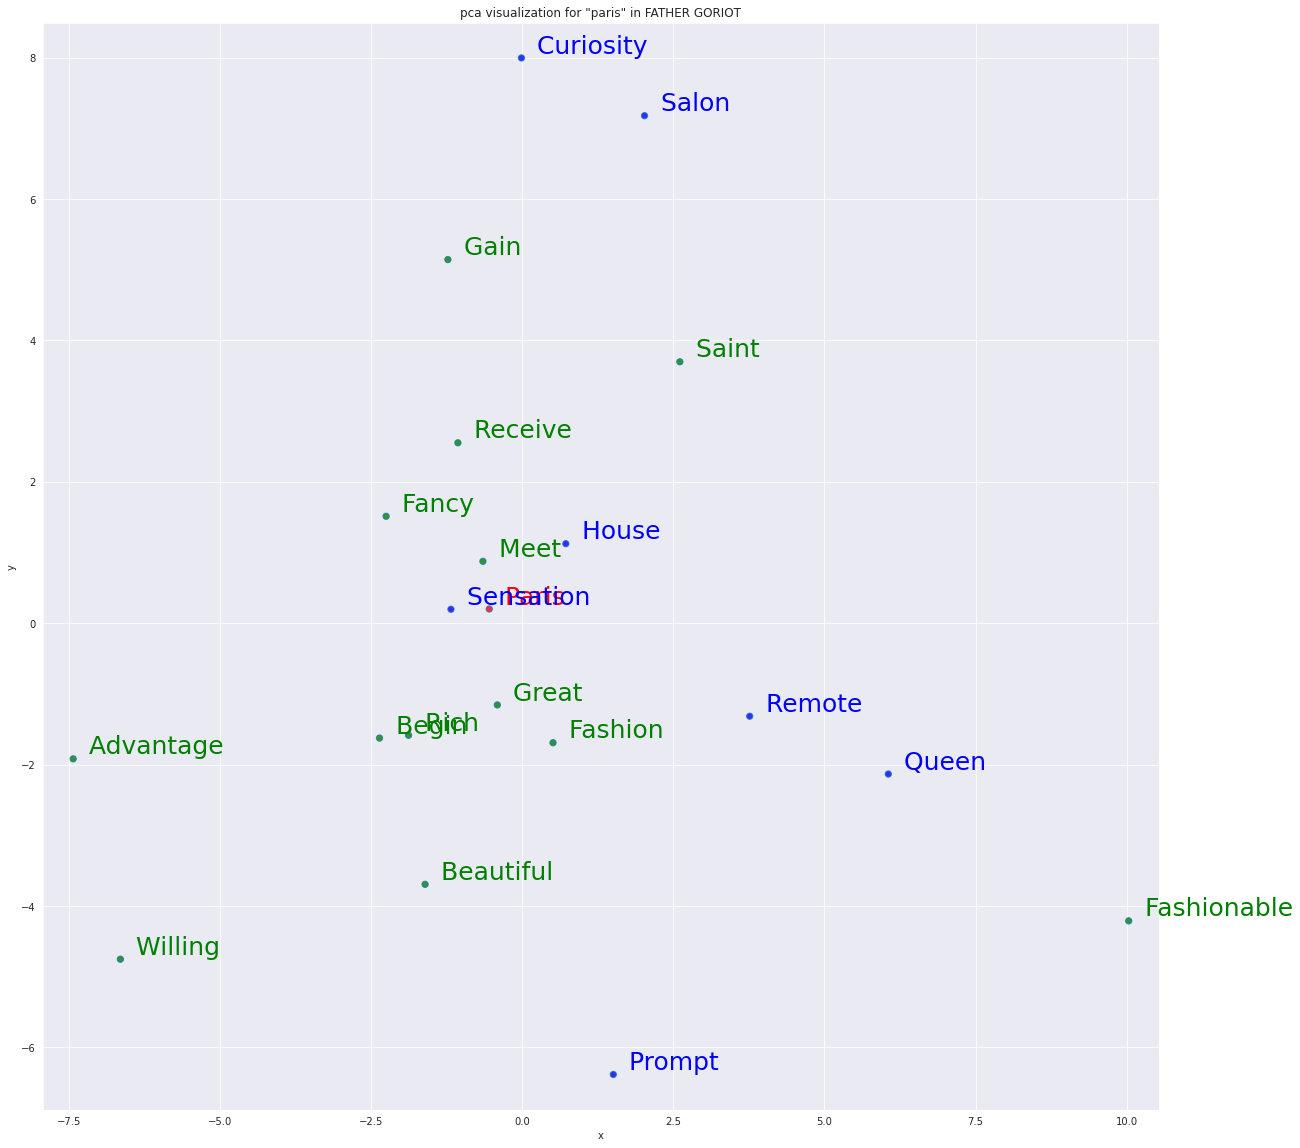

In [16]:
print("\n")
print("#"*60)
query = 'paris'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=[])



############################################################
Query:  paris
K-neigbor words:  ['salon', 'house', 'meet', 'fashionable', 'fashion', 'sensation', 'queen', 'willing', 'remote', 'prompt', 'rich', 'begin', 'gain', 'receive', 'curiosity', 'fancy', 'advantage', 'great', 'beautiful', 'saint']
K-neigbor distances:  [0.2896897792816162, 0.22844421863555908, 0.2156572937965393, 0.20519977807998657, 0.20516762137413025, 0.1995474398136139, 0.19589906930923462, 0.18163923919200897, 0.17569376528263092, 0.17285582423210144, 0.1719389259815216, 0.16954946517944336, 0.16659384965896606, 0.1652809977531433, 0.16499626636505127, 0.16335847973823547, 0.1632084846496582, 0.1613849699497223, 0.16096971929073334, 0.1604880690574646]

	target word: salon
		synset name	positive 	negative 	objective
		 salon.n.01 	 0.0 		 0.0 		 1.0
		 salon.n.02 	 0.0 		 0.0 		 1.0
		 salon.n.03 	 0.0 		 0.0 		 1.0
	 sentiment score of 'salon': 0.0

	target word: house
		synset name	positive 	negative 	object

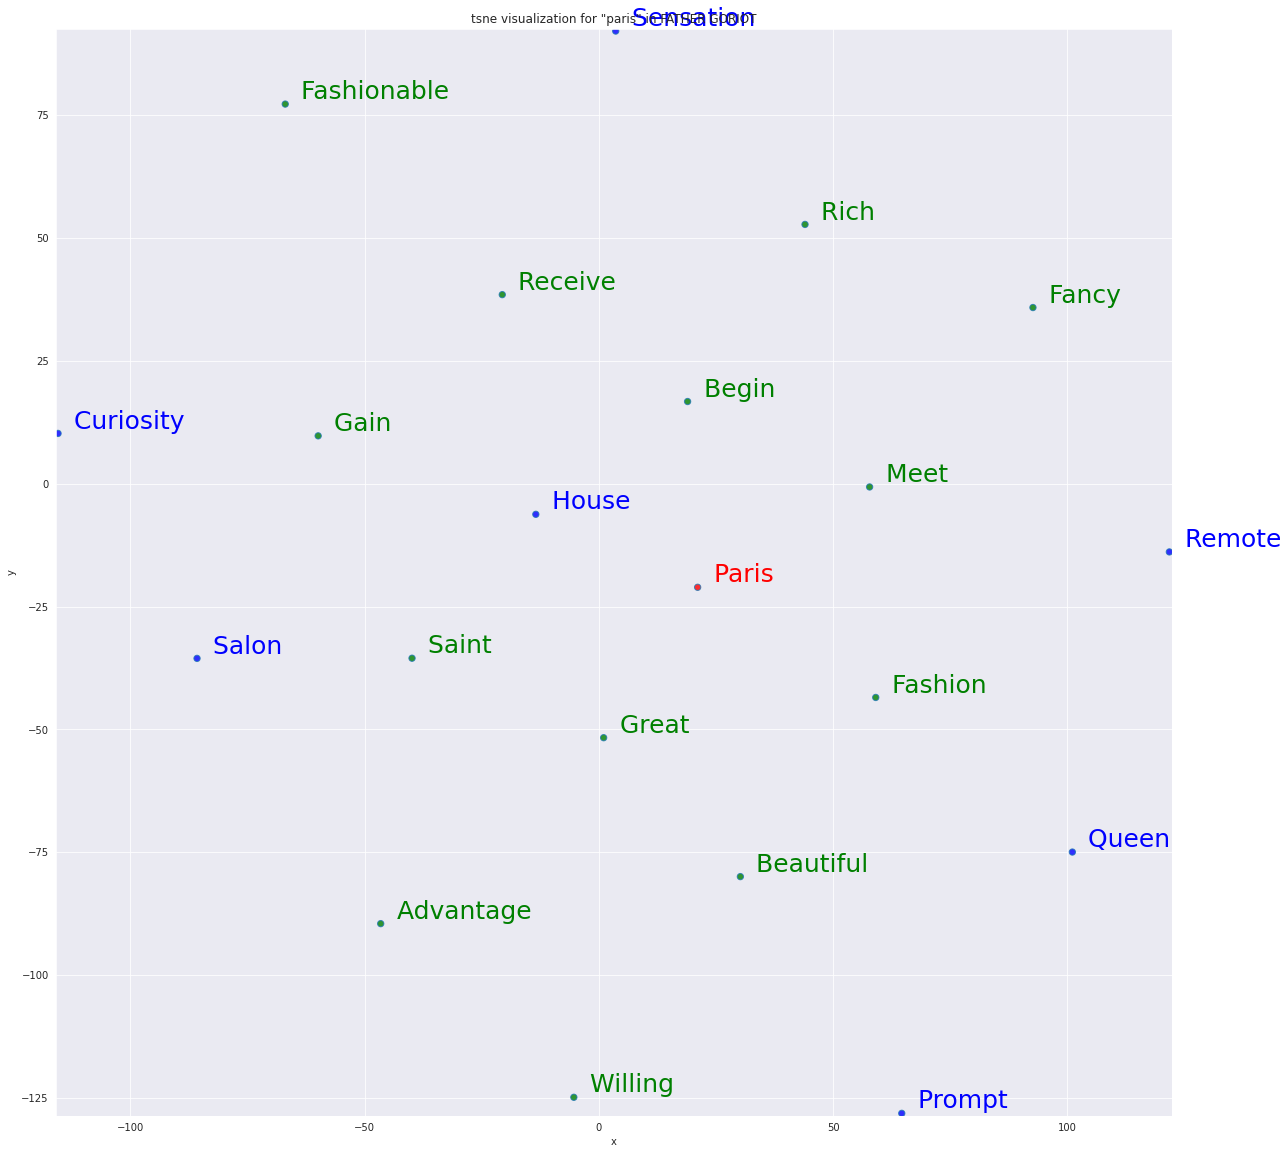

In [17]:
print("\n")
print("#"*60)
query = 'paris'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=[], method='tsne')



############################################################
Query:  paris
K-neigbor words:  ['salon', 'house', 'meet', 'fashionable', 'fashion', 'sensation', 'queen', 'willing', 'remote', 'prompt', 'rich', 'begin', 'gain', 'receive', 'curiosity', 'fancy', 'advantage', 'great', 'beautiful', 'saint', 'enjoy', 'prison', 'wealthy', 'quickly', 'ball', 'graceful', 'woman', 'beauseant', 'world', 'charming', 'citizen', 'court', 'glow', 'dust', 'time', 'young', 'custom', 'eye', 'faubourg', 'fruit', 'public', 'claim', 'learn', 'neat', 'story', 'present', 'experience', 'lead', 'excite', 'plant', 'know', 'person', 'mme_de', 'position', 'criminal', 'de_beauseant', 'use', 'morning', 'realize', 'rise', 'arrangement', 'excitement', 'germain', 'cousin', 'lodging', 'civilization', 'purpose', 'fact', 'vision', 'element', 'behold', 'married', 'affair', 'poverty', 'line', 'produce', 'justice', 'set', 'shine', 'high', 'success', 'respectable', 'adventure', 'color', 'work', 'ground', 'dinner', 'dance', 't

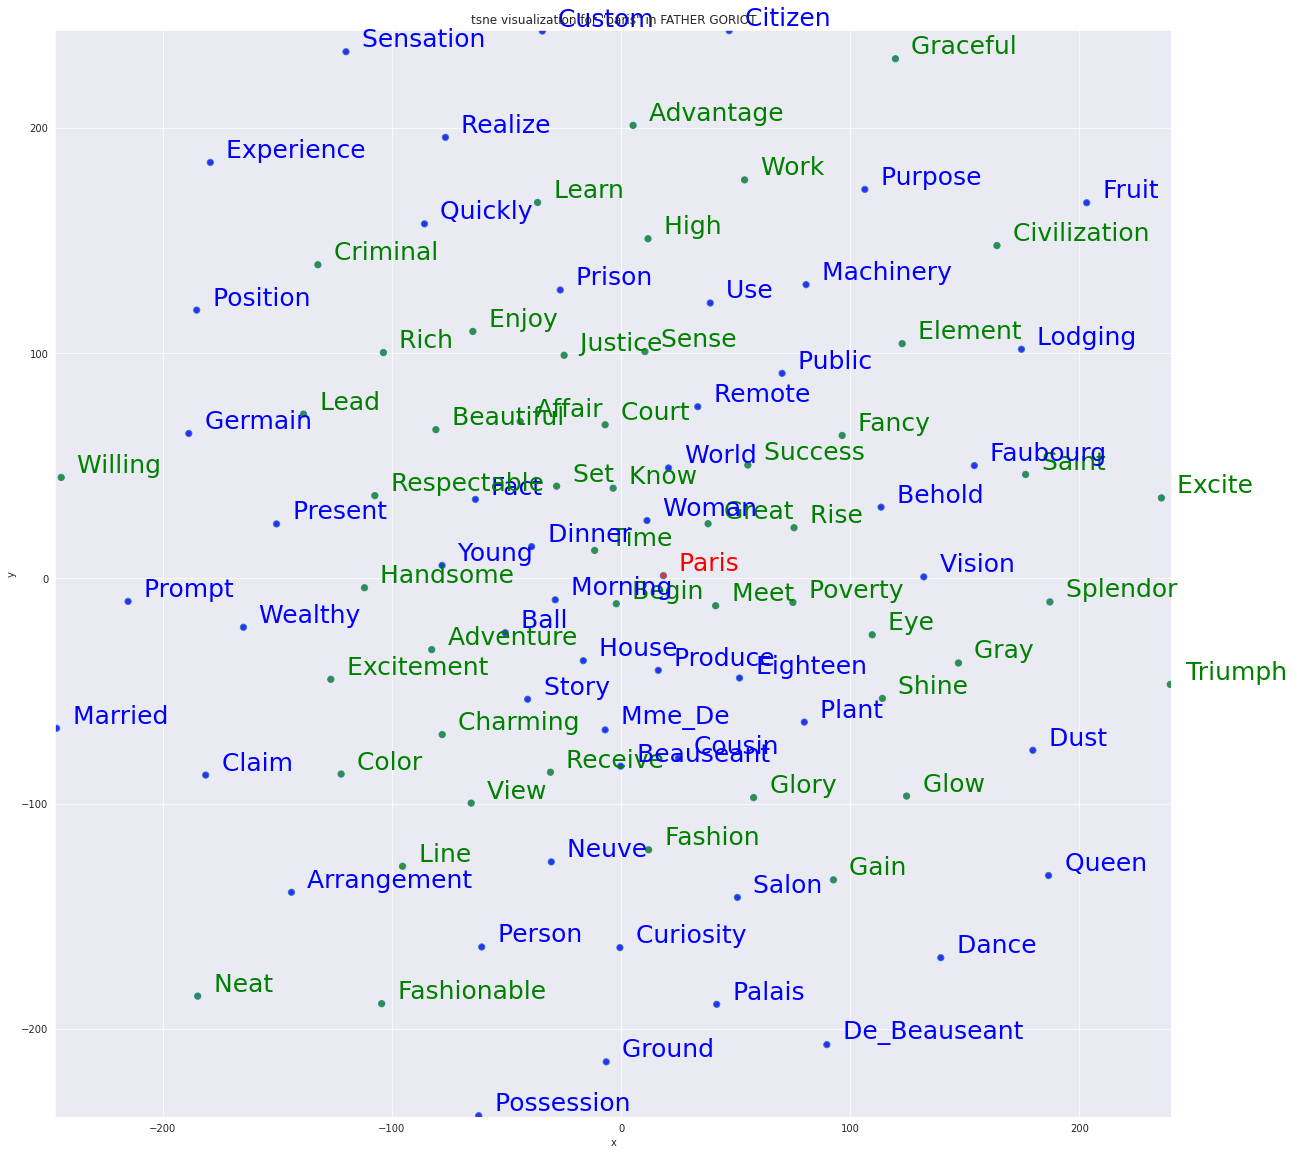

In [19]:
print("\n")
print("#"*60)
query = 'paris'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=100, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=[], method='pca')